# Plotting Records
### Part 3 of 3

This notebook follows sequentially from [NOAA-CO-OPS-data](NOAA-CO-OPS-data.ipynb) in which we downloaded the latest data for a particular NOAA [CO-OPS](https://tidesandcurrents.noaa.gov/) weather and tide station. The data record and corresponding metadata were written to file. Here we use those data and calculates several daily and monthly statistics and records. This is done in two steps:

1. **Filter the data**: We do not perform any quality assurance or quality control checks, but we do remove from the records any days missing a specified amount of data and any months missing a specified number of days of data.
2. **Calculate records**:

   - Daily and monthly averages
   - Record high daily and monthly averages<sup>*</sup>
   - Record low daily and monthly averages<sup>*</sup>
   - Average daily and monthly high
   - Lowest daily and monthly high<sup>*</sup>
   - Record daily and monthly high<sup>*</sup>
   - Average daily and monthly low
   - Highest daily and monthly low<sup>*</sup>
   - Record daily and monthly low<sup>*</sup>

Years are also noted for those records marked by an asterisk (*).

### Packages and configurations

First we import the packages we need.

In [9]:
from scipy.optimize import curve_fit
import plotly.graph_objects as go
from datetime import datetime
import plotly.express as px
import plotly.io as pio
import pandas as pd
import xarray as xr
import numpy as np
import yaml
import os

By default, Python only displays warnings the first time they are thrown. Ideally, we want a code that does not throw any warnings, but it sometimes takes soem trial and error to resolve the issue being warned about. So, for diagnostic purposes, we'll set the kernel to always display warnings.

In [2]:
import warnings
warnings.filterwarnings('always')

### Functions

Next, we define a number of functions that will come in handy later.

#### Helper functions

In [3]:
def camel(text):
    """Convert 'text' to camel case"""
    s = text.replace(',','').replace("-", " ").replace("_", " ")
    s = s.split()
    if len(text) == 0:
        return text
    return s[0].lower() + ''.join(i.capitalize() for i in s[1:])

def DOY(df):
    """Determine year day out of 366"""
    # Day of year as integer
    df['YearDay'] = df.index.day_of_year.astype(int)
    # Years that are NOT leap years
    leapInd = [not calendar.isleap(i) for i in df.index.year]
    mask = (leapInd) & (df.index.month > 2)
    # Advance by one day everything after February 28 
    df.loc[mask, 'YearDay'] += 1
    return df

#### Plotting

In [4]:
def cos_fit(data, plot=False):
    """Fit cosine curve to data"""
    X = np.arange(0, len(data))/len(data)

    # Initial parameter values
    guess_freq = 1
    guess_amplitude = 3*np.std(data)/(2**0.5)
    guess_phase = 0
    guess_offset = np.mean(data)
    p0 = [guess_freq, guess_amplitude,
          guess_phase, guess_offset]

    # Function to fit
    def my_cos(x, freq, amplitude, phase, offset):
        return np.cos(x * freq + phase) * amplitude + offset

    # Fit curve to data
    fit = curve_fit(my_cos, X, data, p0=p0)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))

        ax.plot(data, label=data.name)
        ax.plot(fit, color='red', label=f'Cosine fit')

        ax.legend(loc='best')
        plt.show()
    else:
        return my_cos(np.array(X), *fit[0])

### Loading data

First we need to load in the data and metadata for the desired station. This will be used to determine the directory from which to load the data. 

As before, `stationname` is the custom human-readable "City, ST" string for the station. Since we are not downloading data, we do not need the NOAA-COOPS station ID number.

In [5]:
stationname = 'Virginia Key, FL'

Derive the local directory name containing for data from the station name. This is the same way the directory was created when the data were downloaded.

In [6]:
dirname = camel(stationname)
outdir = os.path.join(os.getcwd(), dirname)

print(f"Station folder: {dirname}")
print(f"Full directory: {outdir}")

Station folder: virginiaKeyFl
Full directory: /home/climatology/virginiaKeyFl


Next, load the data and metadata.

In [7]:
# Metadata
with open(os.path.join(outdir, 'metadata.yml')) as m:
    meta = yaml.safe_load(m)

# Records
days = xr.load_dataset(os.path.join(outdir, 'statistics-daily.nc'))
mons = xr.load_dataset(os.path.join(outdir, 'statistics-monthly.nc'))

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [10]:
today = datetime.today().strftime('%d-%b')

In [53]:
def daily_climo(data, var, scheme='mg'):
    """Create a daily climatology plot for environmental variable 'var'
    from 'data'.
    
    Inputs:
        data: xarray containing climatological stats
        var: str, one of the available environmental variables in 'data'
        scheme: str, either 'mg' or 'bm' specifying whether to use M. Grossi's
            color scheme or B. McNoldy's
        show: Bool, display the plot to screen instead of saving to file
    """

    # Dates for x axis
    xdates = pd.date_range(start='2020-01-01',end='2020-12-31', freq='1D')
    df = data.sel(variable=var)
    
    # Color dictionary
    colors = dict(
        mg=dict({
            'Record High Year': 'white',
            'Record High': '#d26c6c',
            'Average High': '#dc8d8d',
            'Daily Average': '#F5F5F5',
            'Average Low': '#a2bff4',
            'Record Low': '#74a0ef',
            'Record Low Year': 'white'}),
        bm=dict({
            'Record High Year': 'white',
            'Record High': 'orange',
            'Average High': 'red',
            'Daily Average': 'grey',
            'Average Low': 'purple',
            'Record Low': 'white'}        
        ))
    
    # Create figure
    fig = go.Figure()

    # Record highs
    # High records this year
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear).to_dataframe().drop('variable', axis=1)[['Record High Year', 'Record Low Year']].sum().sum()
    lastYearRecords = (df==thisYear-1).to_dataframe().drop('variable', axis=1)[['Record High Year', 'Record Low Year']].sum().sum()
    highRecords = df['Record High'].where(df['Record High Year'] == thisYear).to_dataframe()['Record High']
    highRecords.index = pd.to_datetime(highRecords.index+'-2020')
    lowRecords = df['Record Low'].where(df['Record Low Year'] == thisYear).to_dataframe()['Record Low']
    lowRecords.index = pd.to_datetime(lowRecords.index+'-2020')
    
    first_time = dt.strptime(df.attrs[f'{var} data range'][0], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    last_time = dt.strptime(df.attrs[f'{var} data range'][1], '%Y-%m-%d').strftime('%-m/%-d/%Y')
    fig.add_trace(
    go.Scatter(
        x=highRecords.index, y=highRecords.values,
        name=f'{pd.to_datetime("today").year} Record'.upper(),
        mode='markers',
        marker=dict(size=6, color='white'),
        hovertext=[f'{thisYear} Record: {i}' if not pd.isnull(i) else '' for i in highRecords.values],
        hoverinfo='text'
    ))
    fig.add_trace(
    go.Scatter(
        x=lowRecords.index, y=lowRecords.values,
        name='Low Record',
        mode='markers',
        marker=dict(size=6, color='white'),
        hoverinfo='none'
    ))
    fig.add_trace(
    go.Scatter(
        x=xdates, y=df['Record High'],
        name='Record High'.upper(),
        mode='markers',
        marker=dict(size=3, color=colors[scheme]['Record High'])
    ))
    # Average highs
    fig.add_trace(
    go.Scatter(
        x=xdates, y=cos_fit(df['Average High']).round(1),
        name='Average High'.upper(),
        marker=dict(size=3, color=colors[scheme]['Average High'])
    ))
    # Daily average
    fig.add_trace(
    go.Scatter(
        x=xdates, y=cos_fit(df['Daily Average']).round(1),
        name='Daily Average'.upper(),
        marker=dict(size=3, color=colors[scheme]['Daily Average'])
    ))
    # Average lows
    fig.add_trace(
    go.Scatter(
        x=xdates,
        y=cos_fit(df['Average Low']).round(1),
        name='Average Low'.upper(),
        marker=dict(size=3, color=colors[scheme]['Average Low'])
    ))
    # Record lows
    fig.add_trace(
    go.Scatter(
        x=xdates, y=df['Record Low'],
        name='Record Low'.upper(),
        mode='markers',
        marker=dict(size=3, color=colors[scheme]['Record Low'])
    ))
    # Hover box
    fig.update_traces(
        hoverlabel = dict(bordercolor='white')
    )
    # Plot settings
    fig.update_layout(
        template='plotly_dark',
        paper_bgcolor='#404040',
        plot_bgcolor='#404040',
        height=600, width=1000,
        title=dict(text='Daily {} records'.format(var.lower())+
                        '<br><sup>{}-{}</sup>'.format(first_time, last_time)+
                        '<br><sup>As of today, <b>{}</b> {} record highs/lows have been set. Last year, {} records were set.</sup>'.format(
                            thisYearRecords, var.lower(), lastYearRecords
                        ),
                  font=dict(size=20)),
        yaxis = dict(title=f'{var} ({data.attrs[f"{var} units"]})',
                     showgrid=True, gridcolor='grey'),
        xaxis = dict(showgrid=False, showspikes=True,
                     dtick='M1', tickformat='%b %d'),
        hovermode='x unified',
        legend=dict(itemsizing='constant'),
        hoverlabel=dict(font_size=12)
    )
    for trace in fig['data']: 
        if trace['name'] == 'Low Record':
            trace['showlegend'] = False
    fig.show()

In [54]:
(df==2024).to_dataframe().drop('variable', axis=1)[['Record High Year', 'Record Low Year']].sum()

Record High Year    7
Record Low Year     1
dtype: int64

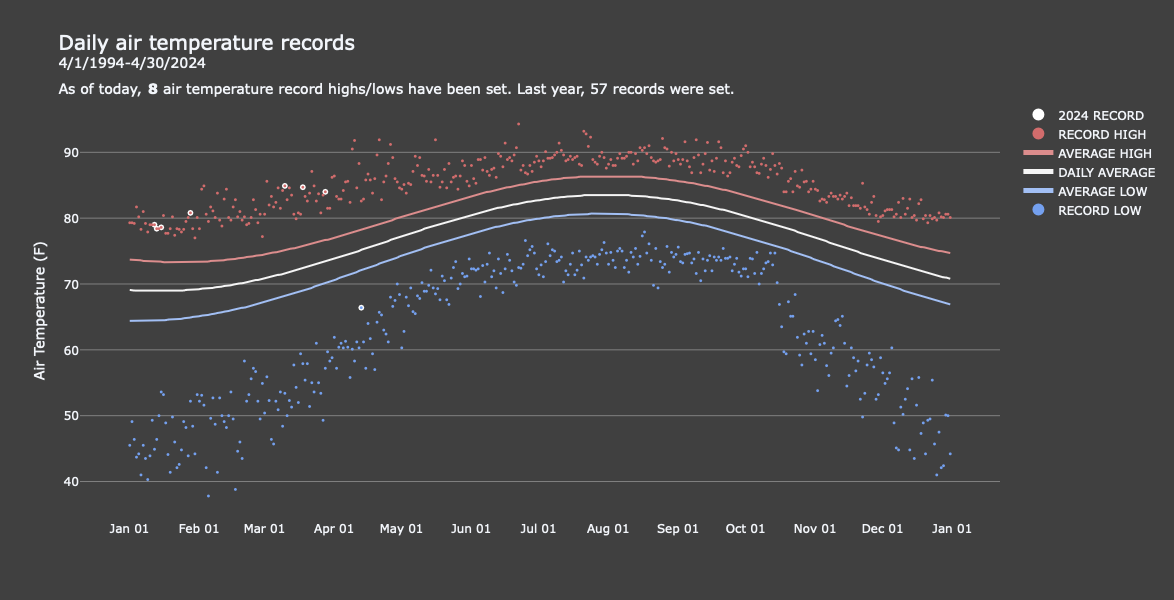

In [55]:
daily_climo(days, 'Air Temperature', scheme='mg')

In [18]:
    df = days.sel(variable='Air Temperature')
    thisYear = pd.to_datetime('today').year
    thisYearRecords = (df==thisYear).to_dataframe().drop('variable', axis=1).sum().sum()
    lastYearRecords = (df==thisYear-1).to_dataframe().drop('variable', axis=1).sum().sum()
    highRecords = df['Record High'].where(df['Record High Year'] == thisYear).to_dataframe()['Record High']
    highRecords.index = pd.to_datetime(highRecords.index+'-2020')
    lowRecords = df['Record Low'].where(df['Record Low Year'] == thisYear).to_dataframe()['Record Low']
    lowRecords.index = pd.to_datetime(lowRecords.index+'-2020')

In [56]:
days

<xarray.Dataset> Size: 103kB
Dimensions:                         (Date: 366, variable: 2)
Coordinates:
  * variable                        (variable) <U17 136B 'Air Temperature' 'W...
  * Date                            (Date) <U6 9kB '01-Jan' ... '31-Dec'
Data variables: (12/16)
    Daily Average                   (Date, variable) float64 6kB 71.5 ... 72.6
    Record High Daily Average       (Date, variable) float64 6kB 78.0 ... 80.5
    Record High Daily Average Year  (Date, variable) int64 6kB 2022 ... 2021
    Record Low Daily Average        (Date, variable) float64 6kB 54.4 ... 66.1
    Record Low Daily Average Year   (Date, variable) int64 6kB 2001 ... 2010
    Average High                    (Date, variable) float64 6kB 75.0 ... 73.9
    ...                              ...
    Average Low                     (Date, variable) float64 6kB 67.9 ... 71.4
    Highest Low                     (Date, variable) float64 6kB 76.8 ... 79.3
    Highest Low Year                (Date, variable) int64 6kB 2022 ... 2021
    Record Low                      (Date, variable) float64 6kB 45.5 ... 64.4
    Record Low Year                 (Date, variable) int64 6kB 2001 ... 2010
    Years                           (Date, variable) int64 6kB 23 24 ... 23 24
Attributes:
    datum:                         MHHW
    day_threshold:                 2
    hr_threshold:                  3
    last_updated:                  2024-05-25 10:00:00
    stationid:                     8723214
    stationname:                   Virginia Key, FL
    tz:                            lst
    unit_system:                   english
    Air Temperature units:         F
    Water Temperature units:       F
    Air Temperature data range:    ['1994-04-01', '2024-04-30']
    Water Temperature data range:  ['1994-04-01', '2024-04-30']

In [26]:
pd.isnull(highRecords.values[0])

True

In [33]:
[f'{thisYear} Record: {i}' if not pd.isnull(i) else '' for i in highRecords.values]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 79.0',
 '2024 Record: 78.4',
 '',
 '2024 Record: 78.6',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 80.8',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.9',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.7',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2024 Record: 84.0',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 

***